# CS591 Final Project: Jazz Solo Markov Generation

In [8]:
import numpy as np
import pandas as pd
from collections import Counter
np.random.seed(42)
from music21 import *
import json
import sqlite3
import re

#database handle
db = sqlite3.connect('wjazzd.db')
db_key = sqlite3.connect('wjazzd.db')

#cursor for melody extraction
cursor = db.cursor()

#cursor for key extraction
cursorKey = db_key.cursor()

cursor.execute('''SELECT pitch FROM melody WHERE melid = 2''')

#Get number of melodies
cursor.execute("SELECT MAX(melid) AS maximum FROM melody")
result = cursor.fetchall()
for i in result:
    numOfmelodies = i[0]


melodies = {}
solo_keys = {}

for mel in range(numOfmelodies):
    
    #set up cursor to get notes of melody i
    command = '''SELECT pitch FROM melody WHERE melid = ?'''
    cursor.execute(command, [mel])
    
    #set up cursor to get get key of melody i
    command = '''SELECT key FROM solo_info WHERE melid = ?'''
    cursorKey.execute(command, [mel])
    
    #get key of each melody
    try:
        solo_key = cursorKey.fetchone()
        solo_keys.update({str(mel): solo_key[0]})
    except Exception:
        pass
    
    #get all notes for each melody
    lis = []
    for notes in cursor:
        notes = cursor.fetchone()
        try:
            lis.append(notes[0])
        except Exception:
            pass
    melodies.update({str(mel): lis})
    
del melodies['0']

# Creating Dictionary for Note Normalization

When going from a C to a G in the key of C, you're going from the 1st to the 5th note <br /> 
When going from a C to a G in the key of G, you're going from the 4th to the 1st note <br /> 
So generating probabilites based off of notes alone would lose the context of the note

The first dictionary, degreeDic, fixes this problem by normalizing the notes to scale degrees <br /> 
The second dictionary, degreeDicRev, is for converting the scale degrees back to notes based on scale being used for the solo and to put them in a form that is able to be converted into a midi

In [9]:
numOfCols = pd.read_excel('DegreeDicR.xlsx')

numOfCol = len(numOfCols.columns)
numOfCol = numOfCol//2

#Create dictionary for converting from notes to scale degrees
degreeDic = {}
j=0
for i in range(numOfCol):
    degreeDic.update(pd.read_excel('DegreeDic.xlsx', index_col=0, usecols = [j,j+1]).to_dict())
    j = j + 2

degreeDic = json.loads(json.dumps(degreeDic), parse_int=str, parse_float=str)


# Create dictionary for converting from scale degrees back to notes
degreeDicRev = {}
h=0
for i in range(numOfCol):
    degreeDicRev.update(pd.read_excel('degreeDicR.xlsx', index_col=0, usecols = [h,h+1]).to_dict())
    h = h + 2

degreeDicRev = json.loads(json.dumps(degreeDicRev), parse_int=str, parse_float=str)

In [10]:
chordDic = pd.read_excel('chordDic.xls', index_col=0, usecols = "A:B", header=None).to_dict()[1]

# Generating Probability Distributions for Bigrams
The following cell counts the occurences of each bigram of notes in each jazz solo from the database and then combines the counts of all solos </br>
Based off of the number of occurences of the bigram versus the total count, a probability distribution is created for every possible note for each possible next note </br>

Due to the difference in the intervals for major keys and minor keys the probabilities are generated seperately </br>
The minor key probability distributions were generated in another file and are stored in the variable all_countsMin here </br>



In [11]:
#Normalize notes to scale degrees
def getScaleDegrees(keyName, noteList):
    soloDataDegrees = []
    for i in melodies[noteList]:
        try:
            soloDataDegrees.append(degreeDic[keyName][str((i))])
        except Exception:
            try:
                soloDataDegrees.append(degreeDic[keyName][str(int(i))])
            except Exception:
                pass
    return (soloDataDegrees)

#Count the number of bigrams for each solo
def count_bigrams(note:str, data:list):
    """Predict next note based on current state."""
    bigrams = data
    # create list of bigrams which starts with current note
    bigrams_with_current_note = [bigram for bigram in bigrams if bigram.split(' ')[0]==note]
    # count appearance of each bigram
    count_appearance = dict(Counter(bigrams_with_current_note))

    return (count_appearance)


def get_count_ofeach_bigram(melid):   
    n = 2
    ngrams = zip(*[getScaleDegrees(solo_keys[melid], melid)[i:] for i in range(n)])
    bigrams = [" ".join(ngram) for ngram in ngrams]

    allProb = {}
    uniqueNotes = list(set(getScaleDegrees(solo_keys[melid], melid)))

    for n in uniqueNotes:
        allProb[n] = count_bigrams(n, bigrams)
    return(allProb)
    

#Combine the counts for an individual solo
def combine_counts(start_mel, new_melnum):
    new_mel = get_count_ofeach_bigram(new_melnum)

    #outer forloop: check if a note in mel2 is in mel1
    for notez in new_mel:
        #if note in mel 2 is in mel 1, 
        if notez in start_mel:
            #for every bigram of mel 2 note, check if there exists bigram of note in mel1
            for j in new_mel[notez]:
                if j in start_mel[notez]:
                    start_mel[notez][j] = start_mel[notez][j] + new_mel[notez][j]
                else:
                    start_mel[notez][j] = new_mel[notez][j]
        
        else:
            start_mel[notez]=new_mel[notez]
        
    return(start_mel)


#Combine the counts for all solos
def combine_all(full, melnum):
    
    if melnum == len(melodies) + 1:
#         print(melnum)
        return(full)
    else:
        full = combine_counts(full, str(melnum))
        return(combine_all(full, melnum+1))

count_of_first_mel = get_count_ofeach_bigram('1')   
all_counts = combine_all(count_of_first_mel, 2)
for uniqueNotes in all_counts:
    total = sum(all_counts[uniqueNotes].values())
    for bgs in all_counts[uniqueNotes]:
        all_counts[uniqueNotes][bgs] = (all_counts[uniqueNotes][bgs]/total)
all_countsMaj = all_counts

In [12]:
#Probability distribution for minor keys
all_countsMin = {'29.5': {'29.5 28.0': 0.14345991561181434, '29.5 28.5': 0.11814345991561181, '29.5 29.5': 0.08016877637130802, '29.5 27.5': 0.0970464135021097, '29.5 31.0': 0.05485232067510549, '29.5 27.0': 0.08438818565400844, '29.5 17.0': 0.004219409282700422, '29.5 29.0': 0.08860759493670886, '29.5 30.0': 0.04219409282700422, '29.5 25.0': 0.02109704641350211, '29.5 26.0': 0.05485232067510549, '29.5 25.5': 0.05063291139240506, '29.5 26.5': 0.012658227848101266, '29.5 30.5': 0.008438818565400843, '29.5 32.5': 0.03375527426160337, '29.5 33.0': 0.02109704641350211, '29.5 34.0': 0.012658227848101266, '29.5 31.5': 0.02531645569620253, '29.5 32.0': 0.02531645569620253, '29.5 24.0': 0.008438818565400843, '29.5 19.0': 0.008438818565400843, '29.5 23.0': 0.004219409282700422}, '28.5': {'28.5 27.5': 0.143646408839779, '28.5 29.5': 0.049723756906077346, '28.5 25.5': 0.06353591160220995, '28.5 26.0': 0.15469613259668508, '28.5 28.5': 0.09944751381215469, '28.5 32.0': 0.03038674033149171, '28.5 28.0': 0.10220994475138122, '28.5 33.0': 0.011049723756906077, '28.5 31.5': 0.016574585635359115, '28.5 29.0': 0.06353591160220995, '28.5 13.5': 0.0027624309392265192, '28.5 31.0': 0.04143646408839779, '28.5 27.0': 0.08011049723756906, '28.5 32.5': 0.0055248618784530384, '28.5 25.0': 0.04419889502762431, '28.5 30.0': 0.019337016574585635, '28.5 22.5': 0.0055248618784530384, '28.5 24.0': 0.03038674033149171, '28.5 24.5': 0.013812154696132596, '28.5 17.0': 0.0027624309392265192, '28.5 21.5': 0.0027624309392265192, '28.5 20.5': 0.0027624309392265192, '28.5 17.5': 0.0027624309392265192, '28.5 15.5': 0.0027624309392265192, '28.5 14.0': 0.0027624309392265192, '28.5 18.5': 0.0027624309392265192, '28.5 22.0': 0.0027624309392265192}, '27.5': {'27.5 28.0': 0.03203342618384401, '27.5 23.0': 0.027855153203342618, '27.5 31.0': 0.016713091922005572, '27.5 21.0': 0.006963788300835654, '27.5 26.0': 0.14623955431754876, '27.5 25.0': 0.08774373259052924, '27.5 27.5': 0.1392757660167131, '27.5 22.5': 0.018105849582172703, '27.5 29.5': 0.027855153203342618, '27.5 28.5': 0.054317548746518104, '27.5 22.0': 0.009749303621169917, '27.5 13.5': 0.005571030640668524, '27.5 23.5': 0.006963788300835654, '27.5 25.5': 0.07242339832869081, '27.5 29.0': 0.08217270194986072, '27.5 20.5': 0.002785515320334262, '27.5 24.5': 0.052924791086350974, '27.5 21.5': 0.009749303621169917, '27.5 27.0': 0.05013927576601671, '27.5 30.0': 0.026462395543175487, '27.5 24.0': 0.08635097493036212, '27.5 32.0': 0.009749303621169917, '27.5 33.5': 0.001392757660167131, '27.5 30.5': 0.006963788300835654, '27.5 31.5': 0.001392757660167131, '27.5 18.5': 0.001392757660167131, '27.5 17.0': 0.001392757660167131, '27.5 17.5': 0.002785515320334262, '27.5 15.0': 0.001392757660167131, '27.5 34.5': 0.001392757660167131, '27.5 33.0': 0.004178272980501393, '27.5 26.5': 0.001392757660167131, '27.5 19.5': 0.001392757660167131, '27.5 19.0': 0.001392757660167131, '27.5 39.5': 0.001392757660167131}, '25.0': {'25.0 25.0': 0.19440914866581957, '25.0 30.0': 0.005717916137229987, '25.0 24.0': 0.12515883100381195, '25.0 27.0': 0.054637865311308764, '25.0 25.5': 0.03748411689961881, '25.0 21.0': 0.027318932655654382, '25.0 21.5': 0.02096569250317662, '25.0 28.5': 0.009529860228716646, '25.0 29.0': 0.01588310038119441, '25.0 23.0': 0.09783989834815757, '25.0 26.0': 0.096569250317662, '25.0 24.5': 0.030495552731893267, '25.0 22.5': 0.03303684879288437, '25.0 22.0': 0.11054637865311309, '25.0 20.0': 0.01207115628970775, '25.0 26.5': 0.007623888182973317, '25.0 27.5': 0.03811944091486658, '25.0 23.5': 0.019695044472681066, '25.0 19.0': 0.005717916137229987, '25.0 28.0': 0.03430749682337993, '25.0 29.5': 0.0031766200762388818, '25.0 31.5': 0.0012706480304955528, '25.0 32.0': 0.0031766200762388818, '25.0 20.5': 0.005717916137229987, '25.0 32.5': 0.0006353240152477764, '25.0 30.5': 0.0006353240152477764, '25.0 18.5': 0.0012706480304955528, '25.0 17.0': 0.0006353240152477764, '25.0 15.5': 0.0012706480304955528, '25.0 33.0': 0.0012706480304955528, '25.0 31.0': 0.0031766200762388818, '25.0 34.0': 0.0006353240152477764}, '20.5': {'20.5 13.5': 0.0030816640986132513, '20.5 19.0': 0.12018489984591679, '20.5 25.0': 0.032357473035439135, '20.5 14.0': 0.004622496147919877, '20.5 18.5': 0.040061633281972264, '20.5 27.5': 0.012326656394453005, '20.5 21.5': 0.05238828967642527, '20.5 15.5': 0.007704160246533128, '20.5 16.0': 0.026194144838212634, '20.5 21.0': 0.046224961479198766, '20.5 22.0': 0.13559322033898305, '20.5 20.0': 0.04468412942989214, '20.5 18.0': 0.04930662557781202, '20.5 17.0': 0.04468412942989214, '20.5 19.5': 0.02465331278890601, '20.5 23.0': 0.07704160246533127, '20.5 24.0': 0.04930662557781202, '20.5 20.5': 0.08320493066255778, '20.5 23.5': 0.02157164869029276, '20.5 22.5': 0.03543913713405239, '20.5 11.5': 0.0030816640986132513, '20.5 25.5': 0.01386748844375963, '20.5 26.0': 0.01848998459167951, '20.5 30.0': 0.0015408320493066256, '20.5 15.0': 0.0030816640986132513, '20.5 17.5': 0.015408320493066256, '20.5 24.5': 0.007704160246533128, '20.5 27.0': 0.01078582434514638, '20.5 28.5': 0.0030816640986132513, '20.5 12.0': 0.0015408320493066256, '20.5 28.0': 0.0015408320493066256, '20.5 29.0': 0.004622496147919877, '20.5 30.5': 0.0015408320493066256, '20.5 16.5': 0.0030816640986132513}, '22.0': {'22.0 24.0': 0.1199213630406291, '22.0 28.0': 0.00655307994757536, '22.0 26.0': 0.07404980340760157, '22.0 17.0': 0.010484927916120577, '22.0 27.5': 0.022280471821756225, '22.0 20.0': 0.03604193971166448, '22.0 22.0': 0.1474442988204456, '22.0 25.0': 0.0910878112712975, '22.0 24.5': 0.02621231979030144, '22.0 21.0': 0.06880733944954129, '22.0 27.0': 0.011795543905635648, '22.0 22.5': 0.028833551769331587, '22.0 13.0': 0.001310615989515072, '22.0 23.0': 0.07470511140235911, '22.0 14.0': 0.000655307994757536, '22.0 20.5': 0.04652686762778506, '22.0 17.5': 0.002621231979030144, '22.0 28.5': 0.00327653997378768, '22.0 30.0': 0.001310615989515072, '22.0 19.0': 0.06815203145478375, '22.0 23.5': 0.019003931847968544, '22.0 16.5': 0.005242463958060288, '22.0 19.5': 0.005242463958060288, '22.0 29.0': 0.010484927916120577, '22.0 18.5': 0.01310615989515072, '22.0 21.5': 0.027522935779816515, '22.0 25.5': 0.0327653997378768, '22.0 18.0': 0.03211009174311927, '22.0 16.0': 0.001965923984272608, '22.0 15.0': 0.002621231979030144, '22.0 34.0': 0.000655307994757536, '22.0 15.5': 0.000655307994757536, '22.0 31.0': 0.001310615989515072, '22.0 30.5': 0.000655307994757536, '22.0 32.0': 0.001310615989515072, '22.0 8.5': 0.000655307994757536, '22.0 29.5': 0.001310615989515072, '22.0 26.5': 0.001310615989515072}, '24.0': {'24.0 20.0': 0.02690863579474343, '24.0 21.5': 0.03754693366708386, '24.0 26.0': 0.09949937421777222, '24.0 22.5': 0.05381727158948686, '24.0 25.0': 0.08635794743429287, '24.0 25.5': 0.05819774718397998, '24.0 24.5': 0.023153942428035045, '24.0 24.0': 0.18147684605757197, '24.0 27.0': 0.023153942428035045, '24.0 23.0': 0.08260325406758448, '24.0 27.5': 0.03504380475594493, '24.0 31.0': 0.0031289111389236545, '24.0 29.0': 0.015018773466833541, '24.0 21.0': 0.05193992490613267, '24.0 22.0': 0.10888610763454318, '24.0 28.5': 0.009386733416770964, '24.0 34.5': 0.0018773466833541927, '24.0 20.5': 0.025031289111389236, '24.0 28.0': 0.028785982478097622, '24.0 19.0': 0.02002503128911139, '24.0 17.0': 0.0031289111389236545, '24.0 18.5': 0.004380475594493116, '24.0 29.5': 0.0031289111389236545, '24.0 37.0': 0.0006257822277847309, '24.0 23.5': 0.0050062578222778474, '24.0 19.5': 0.0006257822277847309, '24.0 16.5': 0.0006257822277847309, '24.0 26.5': 0.0012515644555694619, '24.0 32.0': 0.0012515644555694619, '24.0 15.0': 0.0006257822277847309, '24.0 33.0': 0.0006257822277847309, '24.0 18.0': 0.0012515644555694619, '24.0 32.5': 0.0012515644555694619, '24.0 14.0': 0.0006257822277847309, '24.0 13.0': 0.0006257822277847309, '24.0 31.5': 0.0006257822277847309, '24.0 35.5': 0.0006257822277847309, '24.0 35.0': 0.0006257822277847309, '24.0 30.0': 0.0012515644555694619}, '24.5': {'24.5 26.0': 0.09110169491525423, '24.5 25.0': 0.12076271186440678, '24.5 21.5': 0.05084745762711865, '24.5 27.0': 0.0614406779661017, '24.5 24.5': 0.08898305084745763, '24.5 24.0': 0.1059322033898305, '24.5 21.0': 0.023305084745762712, '24.5 25.5': 0.0635593220338983, '24.5 23.0': 0.11652542372881355, '24.5 22.5': 0.0614406779661017, '24.5 22.0': 0.05084745762711865, '24.5 27.5': 0.0423728813559322, '24.5 29.0': 0.00847457627118644, '24.5 28.0': 0.03389830508474576, '24.5 34.0': 0.00211864406779661, '24.5 28.5': 0.014830508474576272, '24.5 20.5': 0.025423728813559324, '24.5 19.0': 0.01059322033898305, '24.5 20.0': 0.023305084745762712, '24.5 31.0': 0.00211864406779661, '24.5 33.0': 0.00211864406779661}, '32.5': {'32.5 34.5': 0.025, '32.5 28.5': 0.03333333333333333, '32.5 31.5': 0.041666666666666664, '32.5 29.5': 0.041666666666666664, '32.5 32.5': 0.21666666666666667, '32.5 31.0': 0.175, '32.5 30.5': 0.025, '32.5 32.0': 0.1, '32.5 35.0': 0.008333333333333333, '32.5 35.5': 0.016666666666666666, '32.5 20.0': 0.008333333333333333, '32.5 27.0': 0.008333333333333333, '32.5 30.0': 0.041666666666666664, '32.5 34.0': 0.1, '32.5 33.0': 0.058333333333333334, '32.5 33.5': 0.008333333333333333, '32.5 25.5': 0.008333333333333333, '32.5 29.0': 0.05, '32.5 15.0': 0.016666666666666666, '32.5 27.5': 0.008333333333333333, '32.5 36.0': 0.008333333333333333}, '30.0': {'30.0 29.5': 0.04946996466431095, '30.0 28.0': 0.11307420494699646, '30.0 34.0': 0.007067137809187279, '30.0 26.0': 0.06007067137809187, '30.0 23.0': 0.0035335689045936395, '30.0 29.0': 0.15901060070671377, '30.0 28.5': 0.06713780918727916, '30.0 25.5': 0.02120141342756184, '30.0 30.0': 0.14487632508833923, '30.0 32.0': 0.09187279151943463, '30.0 27.0': 0.038869257950530034, '30.0 31.5': 0.045936395759717315, '30.0 27.5': 0.06713780918727916, '30.0 30.5': 0.0035335689045936395, '30.0 33.0': 0.038869257950530034, '30.0 13.5': 0.0035335689045936395, '30.0 31.0': 0.04240282685512368, '30.0 32.5': 0.01060070671378092, '30.0 22.5': 0.0035335689045936395, '30.0 24.0': 0.01060070671378092, '30.0 35.0': 0.0035335689045936395, '30.0 37.0': 0.0035335689045936395, '30.0 25.0': 0.007067137809187279, '30.0 18.0': 0.0035335689045936395}, '17.0': {'17.0 15.0': 0.11545293072824156, '17.0 21.5': 0.021314387211367674, '17.0 20.0': 0.04085257548845471, '17.0 19.0': 0.14209591474245115, '17.0 13.0': 0.021314387211367674, '17.0 27.0': 0.003552397868561279, '17.0 18.5': 0.06039076376554174, '17.0 22.5': 0.010657193605683837, '17.0 18.0': 0.08703374777975133, '17.0 14.0': 0.03197158081705151, '17.0 17.0': 0.11545293072824156, '17.0 16.0': 0.06927175843694494, '17.0 21.0': 0.05328596802841918, '17.0 15.5': 0.03374777975133215, '17.0 10.0': 0.003552397868561279, '17.0 13.5': 0.021314387211367674, '17.0 14.5': 0.02664298401420959, '17.0 22.0': 0.010657193605683837, '17.0 17.5': 0.014209591474245116, '17.0 25.0': 0.008880994671403197, '17.0 20.5': 0.03907637655417407, '17.0 11.0': 0.003552397868561279, '17.0 12.0': 0.02486678507992895, '17.0 30.0': 0.003552397868561279, '17.0 23.5': 0.003552397868561279, '17.0 12.5': 0.0017761989342806395, '17.0 16.5': 0.003552397868561279, '17.0 23.0': 0.0053285968028419185, '17.0 26.0': 0.003552397868561279, '17.0 24.5': 0.0017761989342806395, '17.0 28.0': 0.0053285968028419185, '17.0 25.5': 0.0017761989342806395, '17.0 11.5': 0.003552397868561279, '17.0 24.0': 0.003552397868561279, '17.0 28.5': 0.0017761989342806395, '17.0 29.0': 0.0017761989342806395}, '20.0': {'20.0 18.0': 0.07532051282051282, '20.0 17.0': 0.0625, '20.0 21.0': 0.07852564102564102, '20.0 20.5': 0.052884615384615384, '20.0 22.5': 0.057692307692307696, '20.0 24.0': 0.05448717948717949, '20.0 25.0': 0.017628205128205128, '20.0 18.5': 0.08814102564102565, '20.0 21.5': 0.049679487179487176, '20.0 22.0': 0.10737179487179487, '20.0 19.0': 0.0673076923076923, '20.0 23.0': 0.04326923076923077, '20.0 23.5': 0.003205128205128205, '20.0 26.0': 0.01282051282051282, '20.0 15.5': 0.03365384615384615, '20.0 20.0': 0.08012820512820513, '20.0 14.0': 0.003205128205128205, '20.0 19.5': 0.009615384615384616, '20.0 16.5': 0.004807692307692308, '20.0 25.5': 0.009615384615384616, '20.0 29.5': 0.0016025641025641025, '20.0 27.0': 0.009615384615384616, '20.0 15.0': 0.019230769230769232, '20.0 24.5': 0.009615384615384616, '20.0 16.0': 0.016025641025641024, '20.0 14.5': 0.0016025641025641025, '20.0 17.5': 0.016025641025641024, '20.0 28.5': 0.0016025641025641025, '20.0 27.5': 0.0016025641025641025, '20.0 11.5': 0.0016025641025641025, '20.0 13.0': 0.003205128205128205, '20.0 32.5': 0.0016025641025641025, '20.0 43.0': 0.0016025641025641025, '20.0 26.5': 0.0016025641025641025, '20.0 28.0': 0.0016025641025641025}, '27.0': {'27.0 25.5': 0.10945945945945947, '27.0 26.0': 0.12567567567567567, '27.0 29.0': 0.05540540540540541, '27.0 27.0': 0.13108108108108107, '27.0 28.0': 0.06891891891891892, '27.0 22.5': 0.03513513513513514, '27.0 25.0': 0.12297297297297298, '27.0 29.5': 0.02027027027027027, '27.0 24.5': 0.0445945945945946, '27.0 28.5': 0.03648648648648649, '27.0 30.0': 0.01756756756756757, '27.0 24.0': 0.06621621621621622, '27.0 31.0': 0.025675675675675677, '27.0 23.0': 0.02027027027027027, '27.0 23.5': 0.002702702702702703, '27.0 21.5': 0.014864864864864866, '27.0 20.0': 0.002702702702702703, '27.0 27.5': 0.032432432432432434, '27.0 19.5': 0.0013513513513513514, '27.0 34.0': 0.004054054054054054, '27.0 33.0': 0.002702702702702703, '27.0 32.0': 0.00945945945945946, '27.0 31.5': 0.0013513513513513514, '27.0 21.0': 0.016216216216216217, '27.0 32.5': 0.0013513513513513514, '27.0 18.0': 0.002702702702702703, '27.0 22.0': 0.013513513513513514, '27.0 17.5': 0.0013513513513513514, '27.0 20.5': 0.002702702702702703, '27.0 13.5': 0.0013513513513513514, '27.0 13.0': 0.0013513513513513514, '27.0 11.5': 0.0013513513513513514, '27.0 19.0': 0.002702702702702703, '27.0 15.0': 0.0013513513513513514, '27.0 26.5': 0.0013513513513513514, '27.0 35.0': 0.0013513513513513514}, '15.0': {'15.0 18.0': 0.0856353591160221, '15.0 29.5': 0.0027624309392265192, '15.0 13.0': 0.055248618784530384, '15.0 16.0': 0.049723756906077346, '15.0 17.5': 0.04143646408839779, '15.0 19.0': 0.08011049723756906, '15.0 19.5': 0.008287292817679558, '15.0 18.5': 0.019337016574585635, '15.0 20.5': 0.011049723756906077, '15.0 15.5': 0.03038674033149171, '15.0 14.0': 0.06629834254143646, '15.0 23.0': 0.0027624309392265192, '15.0 20.0': 0.019337016574585635, '15.0 17.0': 0.15193370165745856, '15.0 15.0': 0.13259668508287292, '15.0 12.0': 0.055248618784530384, '15.0 21.0': 0.027624309392265192, '15.0 11.0': 0.008287292817679558, '15.0 25.0': 0.008287292817679558, '15.0 12.5': 0.0027624309392265192, '15.0 16.5': 0.008287292817679558, '15.0 22.0': 0.019337016574585635, '15.0 14.5': 0.03867403314917127, '15.0 13.5': 0.024861878453038673, '15.0 22.5': 0.0027624309392265192, '15.0 26.0': 0.0055248618784530384, '15.0 11.5': 0.008287292817679558, '15.0 28.0': 0.0055248618784530384, '15.0 32.5': 0.0027624309392265192, '15.0 27.5': 0.008287292817679558, '15.0 25.5': 0.0055248618784530384, '15.0 24.0': 0.0055248618784530384, '15.0 23.5': 0.0027624309392265192, '15.0 28.5': 0.0027624309392265192}, '18.5': {'18.5 21.0': 0.10140845070422536, '18.5 18.0': 0.07042253521126761, '18.5 18.5': 0.07605633802816901, '18.5 17.0': 0.09577464788732394, '18.5 20.5': 0.07323943661971831, '18.5 19.0': 0.05070422535211268, '18.5 14.0': 0.016901408450704224, '18.5 20.0': 0.08169014084507042, '18.5 21.5': 0.04788732394366197, '18.5 15.5': 0.04225352112676056, '18.5 22.5': 0.028169014084507043, '18.5 19.5': 0.016901408450704224, '18.5 22.0': 0.036619718309859155, '18.5 16.0': 0.030985915492957747, '18.5 8.5': 0.0028169014084507044, '18.5 13.5': 0.011267605633802818, '18.5 23.0': 0.014084507042253521, '18.5 24.0': 0.022535211267605635, '18.5 12.5': 0.0028169014084507044, '18.5 12.0': 0.005633802816901409, '18.5 15.0': 0.02535211267605634, '18.5 16.5': 0.01971830985915493, '18.5 27.5': 0.005633802816901409, '18.5 17.5': 0.0647887323943662, '18.5 14.5': 0.016901408450704224, '18.5 28.0': 0.008450704225352112, '18.5 25.0': 0.008450704225352112, '18.5 27.0': 0.008450704225352112, '18.5 13.0': 0.0028169014084507044, '18.5 11.5': 0.0028169014084507044, '18.5 25.5': 0.0028169014084507044, '18.5 29.5': 0.0028169014084507044, '18.5 24.5': 0.0028169014084507044}, '21.5': {'21.5 24.0': 0.09878682842287695, '21.5 22.0': 0.08145580589254767, '21.5 23.0': 0.10745233968804159, '21.5 22.5': 0.060658578856152515, '21.5 20.0': 0.06759098786828423, '21.5 25.5': 0.024263431542461005, '21.5 29.5': 0.0017331022530329288, '21.5 18.0': 0.036395147313691506, '21.5 26.0': 0.022530329289428077, '21.5 21.5': 0.08665511265164645, '21.5 19.0': 0.08145580589254767, '21.5 20.5': 0.08838821490467938, '21.5 17.5': 0.022530329289428077, '21.5 21.0': 0.05719237435008666, '21.5 27.0': 0.01559792027729636, '21.5 18.5': 0.025996533795493933, '21.5 25.0': 0.058925476603119586, '21.5 24.5': 0.029462738301559793, '21.5 30.0': 0.0017331022530329288, '21.5 17.0': 0.01733102253032929, '21.5 16.0': 0.0017331022530329288, '21.5 15.5': 0.0017331022530329288, '21.5 28.0': 0.0034662045060658577, '21.5 32.5': 0.0017331022530329288, '21.5 28.5': 0.0017331022530329288, '21.5 14.0': 0.0017331022530329288, '21.5 15.0': 0.0017331022530329288}, '31.0': {'31.0 34.5': 0.01466275659824047, '31.0 35.0': 0.008797653958944282, '31.0 29.0': 0.15542521994134897, '31.0 28.0': 0.08211143695014662, '31.0 31.0': 0.15835777126099707, '31.0 27.5': 0.03812316715542522, '31.0 17.0': 0.002932551319648094, '31.0 28.5': 0.07038123167155426, '31.0 27.0': 0.04985337243401759, '31.0 31.5': 0.020527859237536656, '31.0 22.5': 0.002932551319648094, '31.0 20.5': 0.002932551319648094, '31.0 15.5': 0.002932551319648094, '31.0 30.0': 0.07038123167155426, '31.0 29.5': 0.07331378299120235, '31.0 32.0': 0.06158357771260997, '31.0 24.0': 0.011730205278592375, '31.0 33.5': 0.002932551319648094, '31.0 25.0': 0.008797653958944282, '31.0 18.0': 0.002932551319648094, '31.0 33.0': 0.06744868035190615, '31.0 34.0': 0.01466275659824047, '31.0 32.5': 0.03519061583577713, '31.0 35.5': 0.002932551319648094, '31.0 21.0': 0.002932551319648094, '31.0 25.5': 0.008797653958944282, '31.0 26.0': 0.017595307917888565, '31.0 13.0': 0.002932551319648094, '31.0 37.0': 0.002932551319648094, '31.0 15.0': 0.002932551319648094}, '35.0': {'35.0 28.0': 0.013157894736842105, '35.0 34.0': 0.07894736842105263, '35.0 32.0': 0.11842105263157894, '35.0 33.0': 0.32894736842105265, '35.0 38.5': 0.013157894736842105, '35.0 34.5': 0.039473684210526314, '35.0 36.5': 0.06578947368421052, '35.0 37.0': 0.013157894736842105, '35.0 35.0': 0.09210526315789473, '35.0 35.5': 0.02631578947368421, '35.0 32.5': 0.05263157894736842, '35.0 36.0': 0.05263157894736842, '35.0 23.0': 0.013157894736842105, '35.0 21.0': 0.013157894736842105, '35.0 26.0': 0.013157894736842105, '35.0 14.0': 0.013157894736842105, '35.0 31.0': 0.013157894736842105, '35.0 28.5': 0.013157894736842105, '35.0 29.0': 0.013157894736842105, '35.0 39.5': 0.013157894736842105}, '34.5': {'34.5 28.0': 0.016129032258064516, '34.5 27.5': 0.03225806451612903, '34.5 25.0': 0.016129032258064516, '34.5 31.0': 0.03225806451612903, '34.5 33.0': 0.0967741935483871, '34.5 29.0': 0.03225806451612903, '34.5 32.5': 0.08064516129032258, '34.5 34.5': 0.20967741935483872, '34.5 34.0': 0.03225806451612903, '34.5 32.0': 0.1935483870967742, '34.5 35.5': 0.03225806451612903, '34.5 36.0': 0.016129032258064516, '34.5 35.0': 0.06451612903225806, '34.5 31.5': 0.04838709677419355, '34.5 29.5': 0.03225806451612903, '34.5 22.0': 0.016129032258064516, '34.5 38.5': 0.016129032258064516, '34.5 37.0': 0.016129032258064516, '34.5 30.0': 0.016129032258064516}, '13.5': {'13.5 16.0': 0.10344827586206896, '13.5 13.5': 0.10344827586206896, '13.5 15.0': 0.11206896551724138, '13.5 18.0': 0.034482758620689655, '13.5 14.0': 0.02586206896551724, '13.5 20.5': 0.017241379310344827, '13.5 31.0': 0.008620689655172414, '13.5 19.0': 0.06896551724137931, '13.5 22.0': 0.017241379310344827, '13.5 21.0': 0.017241379310344827, '13.5 12.5': 0.008620689655172414, '13.5 15.5': 0.0603448275862069, '13.5 14.5': 0.05172413793103448, '13.5 12.0': 0.13793103448275862, '13.5 17.0': 0.0603448275862069, '13.5 11.5': 0.017241379310344827, '13.5 10.5': 0.008620689655172414, '13.5 11.0': 0.017241379310344827, '13.5 13.0': 0.034482758620689655, '13.5 25.5': 0.008620689655172414, '13.5 24.0': 0.008620689655172414, '13.5 26.0': 0.017241379310344827, '13.5 17.5': 0.034482758620689655, '13.5 9.0': 0.017241379310344827, '13.5 18.5': 0.008620689655172414}, '23.0': {'23.0 21.5': 0.06587837837837837, '23.0 24.0': 0.08699324324324324, '23.0 19.0': 0.044763513513513514, '23.0 14.0': 0.0016891891891891893, '23.0 25.0': 0.13851351351351351, '23.0 18.0': 0.011824324324324325, '23.0 22.5': 0.03209459459459459, '23.0 28.0': 0.01097972972972973, '23.0 26.0': 0.05405405405405406, '23.0 21.0': 0.08108108108108109, '23.0 22.0': 0.13091216216216217, '23.0 20.5': 0.03969594594594594, '23.0 9.0': 0.0008445945945945946, '23.0 24.5': 0.021114864864864864, '23.0 29.0': 0.008445945945945946, '23.0 18.5': 0.007601351351351352, '23.0 23.0': 0.14273648648648649, '23.0 23.5': 0.01097972972972973, '23.0 27.5': 0.017736486486486486, '23.0 25.5': 0.032939189189189186, '23.0 20.0': 0.02195945945945946, '23.0 11.5': 0.0008445945945945946, '23.0 26.5': 0.004222972972972973, '23.0 19.5': 0.0033783783783783786, '23.0 27.0': 0.016891891891891893, '23.0 16.0': 0.0016891891891891893, '23.0 17.5': 0.002533783783783784, '23.0 29.5': 0.0016891891891891893, '23.0 30.0': 0.0008445945945945946, '23.0 31.0': 0.0008445945945945946, '23.0 28.5': 0.0016891891891891893, '23.0 31.5': 0.0008445945945945946, '23.0 30.5': 0.0008445945945945946, '23.0 17.0': 0.0008445945945945946}, '32.0': {'32.0 34.5': 0.03767123287671233, '32.0 28.5': 0.023972602739726026, '32.0 30.0': 0.09246575342465753, '32.0 28.0': 0.017123287671232876, '32.0 31.0': 0.1232876712328767, '32.0 33.0': 0.06164383561643835, '32.0 29.5': 0.05136986301369863, '32.0 31.5': 0.03767123287671233, '32.0 32.0': 0.2191780821917808, '32.0 29.0': 0.15753424657534246, '32.0 22.0': 0.003424657534246575, '32.0 23.5': 0.003424657534246575, '32.0 32.5': 0.0273972602739726, '32.0 34.0': 0.05136986301369863, '32.0 26.5': 0.003424657534246575, '32.0 25.0': 0.0136986301369863, '32.0 35.0': 0.017123287671232876, '32.0 36.0': 0.003424657534246575, '32.0 36.5': 0.003424657534246575, '32.0 35.5': 0.00684931506849315, '32.0 33.5': 0.003424657534246575, '32.0 30.5': 0.00684931506849315, '32.0 37.0': 0.003424657534246575, '32.0 25.5': 0.003424657534246575, '32.0 24.5': 0.003424657534246575, '32.0 26.0': 0.010273972602739725, '32.0 27.5': 0.003424657534246575, '32.0 15.0': 0.00684931506849315, '32.0 27.0': 0.003424657534246575}, '28.0': {'28.0 28.0': 0.16212534059945505, '28.0 29.0': 0.08446866485013624, '28.0 25.0': 0.09809264305177112, '28.0 27.0': 0.1008174386920981, '28.0 26.0': 0.11852861035422343, '28.0 27.5': 0.0653950953678474, '28.0 31.0': 0.04087193460490463, '28.0 24.0': 0.05858310626702997, '28.0 25.5': 0.06130790190735695, '28.0 30.0': 0.0340599455040872, '28.0 29.5': 0.04223433242506812, '28.0 18.0': 0.0013623978201634877, '28.0 31.5': 0.004087193460490463, '28.0 32.0': 0.008174386920980926, '28.0 24.5': 0.006811989100817439, '28.0 22.5': 0.008174386920980926, '28.0 28.5': 0.027247956403269755, '28.0 32.5': 0.004087193460490463, '28.0 23.0': 0.017711171662125342, '28.0 26.5': 0.005449591280653951, '28.0 13.0': 0.0013623978201634877, '28.0 33.0': 0.006811989100817439, '28.0 34.0': 0.004087193460490463, '28.0 21.0': 0.005449591280653951, '28.0 34.5': 0.0013623978201634877, '28.0 20.5': 0.005449591280653951, '28.0 22.0': 0.010899182561307902, '28.0 20.0': 0.005449591280653951, '28.0 15.5': 0.0013623978201634877, '28.0 13.5': 0.0013623978201634877, '28.0 21.5': 0.004087193460490463, '28.0 16.0': 0.0013623978201634877, '28.0 17.0': 0.0013623978201634877}, '25.5': {'25.5 27.0': 0.07957559681697612, '25.5 26.0': 0.08222811671087533, '25.5 25.5': 0.09151193633952255, '25.5 24.5': 0.07824933687002653, '25.5 25.0': 0.10344827586206896, '25.5 28.5': 0.026525198938992044, '25.5 18.5': 0.001326259946949602, '25.5 28.0': 0.06763925729442971, '25.5 23.0': 0.042440318302387266, '25.5 21.0': 0.03050397877984085, '25.5 29.5': 0.009283819628647215, '25.5 31.0': 0.001326259946949602, '25.5 22.5': 0.04907161803713528, '25.5 24.0': 0.14588859416445624, '25.5 21.5': 0.023872679045092837, '25.5 22.0': 0.042440318302387266, '25.5 20.5': 0.010610079575596816, '25.5 27.5': 0.04509283819628647, '25.5 29.0': 0.025198938992042442, '25.5 26.5': 0.003978779840848806, '25.5 19.5': 0.002652519893899204, '25.5 23.5': 0.01856763925729443, '25.5 20.0': 0.009283819628647215, '25.5 30.0': 0.002652519893899204, '25.5 31.5': 0.001326259946949602, '25.5 18.0': 0.001326259946949602, '25.5 19.0': 0.002652519893899204, '25.5 32.0': 0.001326259946949602}, '34.0': {'34.0 32.0': 0.2, '34.0 28.0': 0.011764705882352941, '34.0 32.5': 0.17647058823529413, '34.0 27.5': 0.011764705882352941, '34.0 34.0': 0.16470588235294117, '34.0 29.5': 0.058823529411764705, '34.0 36.0': 0.047058823529411764, '34.0 33.0': 0.08235294117647059, '34.0 31.5': 0.023529411764705882, '34.0 35.5': 0.023529411764705882, '34.0 34.5': 0.058823529411764705, '34.0 35.0': 0.07058823529411765, '34.0 31.0': 0.047058823529411764, '34.0 29.0': 0.023529411764705882}, '21.0': {'21.0 24.0': 0.07239819004524888, '21.0 27.0': 0.012443438914027148, '21.0 18.0': 0.057692307692307696, '21.0 22.5': 0.058823529411764705, '21.0 15.5': 0.00904977375565611, '21.0 18.5': 0.023755656108597284, '21.0 22.0': 0.09502262443438914, '21.0 20.5': 0.049773755656108594, '21.0 23.0': 0.07126696832579185, '21.0 20.0': 0.08484162895927602, '21.0 28.0': 0.013574660633484163, '21.0 25.0': 0.04072398190045249, '21.0 21.0': 0.1244343891402715, '21.0 21.5': 0.02262443438914027, '21.0 19.0': 0.09276018099547512, '21.0 17.0': 0.027149321266968326, '21.0 17.5': 0.016968325791855202, '21.0 23.5': 0.010180995475113122, '21.0 26.0': 0.027149321266968326, '21.0 27.5': 0.006787330316742082, '21.0 15.0': 0.007918552036199095, '21.0 24.5': 0.013574660633484163, '21.0 29.0': 0.007918552036199095, '21.0 30.0': 0.0022624434389140274, '21.0 10.0': 0.0011312217194570137, '21.0 25.5': 0.016968325791855202, '21.0 35.0': 0.0011312217194570137, '21.0 28.5': 0.0011312217194570137, '21.0 29.5': 0.0011312217194570137, '21.0 16.0': 0.012443438914027148, '21.0 19.5': 0.006787330316742082, '21.0 12.0': 0.0011312217194570137, '21.0 33.0': 0.0011312217194570137, '21.0 31.5': 0.0011312217194570137, '21.0 10.5': 0.0011312217194570137, '21.0 16.5': 0.0022624434389140274, '21.0 26.5': 0.0011312217194570137, '21.0 31.0': 0.0011312217194570137, '21.0 13.5': 0.0011312217194570137}, '22.5': {'22.5 22.0': 0.09936908517350158, '22.5 25.5': 0.03627760252365931, '22.5 21.0': 0.08201892744479496, '22.5 19.0': 0.031545741324921134, '22.5 16.0': 0.0031545741324921135, '22.5 27.0': 0.03470031545741325, '22.5 22.5': 0.07728706624605679, '22.5 23.0': 0.05362776025236593, '22.5 20.0': 0.06466876971608833, '22.5 24.0': 0.07886435331230283, '22.5 21.5': 0.0804416403785489, '22.5 29.5': 0.006309148264984227, '22.5 28.0': 0.017350157728706624, '22.5 18.0': 0.012618296529968454, '22.5 18.5': 0.022082018927444796, '22.5 31.0': 0.0015772870662460567, '22.5 25.0': 0.10252365930599369, '22.5 20.5': 0.052050473186119876, '22.5 26.0': 0.03785488958990536, '22.5 17.0': 0.00946372239747634, '22.5 24.5': 0.050473186119873815, '22.5 27.5': 0.014195583596214511, '22.5 23.5': 0.014195583596214511, '22.5 30.0': 0.0015772870662460567, '22.5 32.0': 0.0015772870662460567, '22.5 19.5': 0.0031545741324921135, '22.5 9.0': 0.0015772870662460567, '22.5 28.5': 0.0015772870662460567, '22.5 13.5': 0.0015772870662460567, '22.5 12.0': 0.0015772870662460567, '22.5 15.0': 0.0015772870662460567, '22.5 26.5': 0.0015772870662460567, '22.5 17.5': 0.0015772870662460567}, '19.0': {'19.0 23.0': 0.05549738219895288, '19.0 24.0': 0.030366492146596858, '19.0 22.5': 0.02617801047120419, '19.0 18.0': 0.09947643979057591, '19.0 20.5': 0.0712041884816754, '19.0 16.0': 0.0387434554973822, '19.0 20.0': 0.049214659685863874, '19.0 21.0': 0.060732984293193716, '19.0 21.5': 0.03769633507853403, '19.0 17.0': 0.07643979057591622, '19.0 15.5': 0.015706806282722512, '19.0 22.0': 0.07853403141361257, '19.0 27.0': 0.0031413612565445027, '19.0 15.0': 0.039790575916230364, '19.0 16.5': 0.01780104712041885, '19.0 23.5': 0.007329842931937173, '19.0 19.5': 0.008376963350785341, '19.0 25.0': 0.013612565445026177, '19.0 14.5': 0.007329842931937173, '19.0 13.0': 0.0031413612565445027, '19.0 19.0': 0.14659685863874344, '19.0 12.0': 0.005235602094240838, '19.0 17.5': 0.025130890052356022, '19.0 27.5': 0.005235602094240838, '19.0 18.5': 0.030366492146596858, '19.0 26.0': 0.015706806282722512, '19.0 24.5': 0.0031413612565445027, '19.0 25.5': 0.004188481675392671, '19.0 14.0': 0.005235602094240838, '19.0 13.5': 0.004188481675392671, '19.0 28.0': 0.007329842931937173, '19.0 29.0': 0.004188481675392671, '19.0 29.5': 0.0010471204188481676, '19.0 30.0': 0.0020942408376963353}, '26.0': {'26.0 25.0': 0.10716591349257586, '26.0 26.0': 0.2130406714009038, '26.0 25.5': 0.046481601032924466, '26.0 21.5': 0.008392511297611363, '26.0 24.5': 0.0329244673983215, '26.0 27.0': 0.04325371207230471, '26.0 24.0': 0.10974822466107166, '26.0 32.0': 0.003873466752743706, '26.0 23.0': 0.06520335700451904, '26.0 29.0': 0.045190445448676564, '26.0 27.5': 0.051646223369916075, '26.0 28.0': 0.05358295674628793, '26.0 22.5': 0.023240800516462233, '26.0 28.5': 0.029051000645577793, '26.0 14.0': 0.0006455777921239509, '26.0 21.0': 0.005164622336991607, '26.0 22.0': 0.08908973531310523, '26.0 30.0': 0.010974822466107165, '26.0 29.5': 0.004519044544867657, '26.0 23.5': 0.015493867010974823, '26.0 20.0': 0.003873466752743706, '26.0 19.0': 0.005810200129115558, '26.0 20.5': 0.008392511297611363, '26.0 26.5': 0.007746933505487412, '26.0 31.0': 0.007746933505487412, '26.0 18.0': 0.0012911555842479018, '26.0 33.0': 0.0032278889606197547, '26.0 34.0': 0.0006455777921239509, '26.0 18.5': 0.0006455777921239509, '26.0 31.5': 0.0012911555842479018, '26.0 32.5': 0.0006455777921239509}, '14.0': {'14.0 26.0': 0.010526315789473684, '14.0 28.0': 0.005263157894736842, '14.0 27.5': 0.005263157894736842, '14.0 13.5': 0.06315789473684211, '14.0 16.0': 0.1, '14.0 15.0': 0.09473684210526316, '14.0 18.0': 0.05263157894736842, '14.0 14.0': 0.11052631578947368, '14.0 10.0': 0.010526315789473684, '14.0 17.0': 0.11052631578947368, '14.0 18.5': 0.04736842105263158, '14.0 17.5': 0.015789473684210527, '14.0 12.0': 0.06842105263157895, '14.0 20.5': 0.010526315789473684, '14.0 14.5': 0.031578947368421054, '14.0 11.0': 0.042105263157894736, '14.0 13.0': 0.03684210526315789, '14.0 19.0': 0.02631578947368421, '14.0 11.5': 0.015789473684210527, '14.0 15.5': 0.08421052631578947, '14.0 24.5': 0.005263157894736842, '14.0 28.5': 0.005263157894736842, '14.0 24.0': 0.010526315789473684, '14.0 20.0': 0.021052631578947368, '14.0 25.0': 0.005263157894736842, '14.0 22.0': 0.005263157894736842, '14.0 16.5': 0.005263157894736842}, '16.0': {'16.0 14.0': 0.05956112852664577, '16.0 18.0': 0.18495297805642633, '16.0 15.5': 0.025078369905956112, '16.0 17.5': 0.0438871473354232, '16.0 19.0': 0.07523510971786834, '16.0 20.0': 0.03761755485893417, '16.0 23.0': 0.03134796238244514, '16.0 22.5': 0.009404388714733543, '16.0 13.5': 0.03134796238244514, '16.0 14.5': 0.06269592476489028, '16.0 18.5': 0.03761755485893417, '16.0 16.0': 0.0877742946708464, '16.0 15.0': 0.08463949843260188, '16.0 21.0': 0.018808777429467086, '16.0 22.0': 0.018808777429467086, '16.0 26.5': 0.003134796238244514, '16.0 17.0': 0.08150470219435736, '16.0 13.0': 0.009404388714733543, '16.0 20.5': 0.04075235109717868, '16.0 19.5': 0.003134796238244514, '16.0 23.5': 0.006269592476489028, '16.0 27.5': 0.006269592476489028, '16.0 31.5': 0.003134796238244514, '16.0 21.5': 0.006269592476489028, '16.0 24.5': 0.006269592476489028, '16.0 28.0': 0.006269592476489028, '16.0 24.0': 0.006269592476489028, '16.0 12.0': 0.012539184952978056}, '18.0': {'18.0 18.0': 0.10213414634146341, '18.0 14.0': 0.024390243902439025, '18.0 17.0': 0.12195121951219512, '18.0 19.0': 0.12804878048780488, '18.0 23.0': 0.021341463414634148, '18.0 22.5': 0.012195121951219513, '18.0 26.0': 0.003048780487804878, '18.0 22.0': 0.0625, '18.0 21.0': 0.06707317073170732, '18.0 20.5': 0.0625, '18.0 14.5': 0.0350609756097561, '18.0 20.0': 0.07469512195121951, '18.0 17.5': 0.021341463414634148, '18.0 18.5': 0.022865853658536585, '18.0 16.5': 0.010670731707317074, '18.0 27.0': 0.003048780487804878, '18.0 16.0': 0.05945121951219512, '18.0 15.0': 0.04573170731707317, '18.0 25.0': 0.006097560975609756, '18.0 15.5': 0.024390243902439025, '18.0 13.0': 0.006097560975609756, '18.0 27.5': 0.003048780487804878, '18.0 21.5': 0.03353658536585366, '18.0 24.0': 0.012195121951219513, '18.0 12.0': 0.004573170731707317, '18.0 19.5': 0.01524390243902439, '18.0 31.0': 0.001524390243902439, '18.0 11.0': 0.001524390243902439, '18.0 13.5': 0.003048780487804878, '18.0 25.5': 0.003048780487804878, '18.0 29.0': 0.003048780487804878, '18.0 23.5': 0.003048780487804878, '18.0 24.5': 0.001524390243902439}, '29.0': {'29.0 28.0': 0.09352517985611511, '29.0 29.0': 0.15827338129496402, '29.0 26.0': 0.1410071942446043, '29.0 28.5': 0.04316546762589928, '29.0 32.5': 0.010071942446043165, '29.0 30.0': 0.05611510791366906, '29.0 27.0': 0.0776978417266187, '29.0 34.0': 0.0057553956834532375, '29.0 27.5': 0.09640287769784173, '29.0 25.5': 0.02302158273381295, '29.0 33.0': 0.017266187050359712, '29.0 29.5': 0.02446043165467626, '29.0 30.5': 0.0028776978417266188, '29.0 24.5': 0.004316546762589928, '29.0 31.0': 0.0776978417266187, '29.0 23.0': 0.008633093525179856, '29.0 25.0': 0.04892086330935252, '29.0 24.0': 0.01870503597122302, '29.0 32.0': 0.05611510791366906, '29.0 31.5': 0.011510791366906475, '29.0 22.0': 0.010071942446043165, '29.0 34.5': 0.0028776978417266188, '29.0 33.5': 0.0014388489208633094, '29.0 26.5': 0.004316546762589928, '29.0 20.5': 0.0014388489208633094, '29.0 12.0': 0.0014388489208633094, '29.0 35.0': 0.0014388489208633094, '29.0 23.5': 0.0014388489208633094}, '15.5': {'15.5 17.0': 0.09502262443438914, '15.5 18.0': 0.12217194570135746, '15.5 16.0': 0.04524886877828054, '15.5 20.5': 0.027149321266968326, '15.5 15.5': 0.06787330316742081, '15.5 17.5': 0.06334841628959276, '15.5 14.5': 0.09049773755656108, '15.5 15.0': 0.08597285067873303, '15.5 21.0': 0.02262443438914027, '15.5 14.0': 0.06787330316742081, '15.5 22.5': 0.004524886877828055, '15.5 24.0': 0.013574660633484163, '15.5 8.5': 0.004524886877828055, '15.5 18.5': 0.049773755656108594, '15.5 16.5': 0.004524886877828055, '15.5 23.0': 0.01809954751131222, '15.5 20.0': 0.04072398190045249, '15.5 10.0': 0.004524886877828055, '15.5 19.0': 0.06787330316742081, '15.5 25.0': 0.00904977375565611, '15.5 22.0': 0.00904977375565611, '15.5 21.5': 0.00904977375565611, '15.5 13.5': 0.00904977375565611, '15.5 12.0': 0.02262443438914027, '15.5 11.5': 0.00904977375565611, '15.5 13.0': 0.013574660633484163, '15.5 27.0': 0.004524886877828055, '15.5 28.5': 0.004524886877828055, '15.5 10.5': 0.004524886877828055, '15.5 19.5': 0.004524886877828055, '15.5 11.0': 0.004524886877828055}, '33.0': {'33.0 33.0': 0.28444444444444444, '33.0 28.0': 0.017777777777777778, '33.0 32.0': 0.09777777777777778, '33.0 35.0': 0.08888888888888889, '33.0 31.0': 0.11555555555555555, '33.0 32.5': 0.02666666666666667, '33.0 29.0': 0.04888888888888889, '33.0 36.0': 0.008888888888888889, '33.0 36.5': 0.03111111111111111, '33.0 31.5': 0.04888888888888889, '33.0 30.0': 0.057777777777777775, '33.0 34.0': 0.022222222222222223, '33.0 34.5': 0.02666666666666667, '33.0 37.0': 0.03111111111111111, '33.0 30.5': 0.017777777777777778, '33.0 33.5': 0.013333333333333334, '33.0 29.5': 0.017777777777777778, '33.0 27.5': 0.013333333333333334, '33.0 26.0': 0.008888888888888889, '33.0 25.5': 0.0044444444444444444, '33.0 28.5': 0.0044444444444444444, '33.0 35.5': 0.008888888888888889, '33.0 38.5': 0.0044444444444444444}, '13.0': {'13.0 31.0': 0.010752688172043012, '13.0 27.5': 0.010752688172043012, '13.0 14.0': 0.03225806451612903, '13.0 13.5': 0.021505376344086023, '13.0 13.0': 0.07526881720430108, '13.0 15.5': 0.06451612903225806, '13.0 18.5': 0.010752688172043012, '13.0 15.0': 0.15053763440860216, '13.0 20.0': 0.03225806451612903, '13.0 10.0': 0.010752688172043012, '13.0 12.5': 0.010752688172043012, '13.0 19.0': 0.03225806451612903, '13.0 17.0': 0.0967741935483871, '13.0 11.0': 0.021505376344086023, '13.0 12.0': 0.043010752688172046, '13.0 16.0': 0.06451612903225806, '13.0 14.5': 0.06451612903225806, '13.0 10.5': 0.021505376344086023, '13.0 25.0': 0.010752688172043012, '13.0 31.5': 0.010752688172043012, '13.0 32.0': 0.010752688172043012, '13.0 17.5': 0.06451612903225806, '13.0 24.0': 0.010752688172043012, '13.0 11.5': 0.03225806451612903, '13.0 27.0': 0.010752688172043012, '13.0 28.0': 0.010752688172043012, '13.0 28.5': 0.010752688172043012, '13.0 21.5': 0.010752688172043012, '13.0 22.0': 0.010752688172043012, '13.0 21.0': 0.010752688172043012, '13.0 18.0': 0.021505376344086023}, '17.5': {'17.5 18.5': 0.07317073170731707, '17.5 19.0': 0.11219512195121951, '17.5 17.5': 0.06829268292682927, '17.5 20.5': 0.06829268292682927, '17.5 15.0': 0.03902439024390244, '17.5 22.5': 0.014634146341463415, '17.5 21.0': 0.06341463414634146, '17.5 16.0': 0.04878048780487805, '17.5 22.0': 0.04390243902439024, '17.5 18.0': 0.07317073170731707, '17.5 20.0': 0.06829268292682927, '17.5 15.5': 0.0975609756097561, '17.5 17.0': 0.02926829268292683, '17.5 24.0': 0.004878048780487805, '17.5 14.0': 0.04390243902439024, '17.5 11.5': 0.004878048780487805, '17.5 14.5': 0.02926829268292683, '17.5 12.0': 0.00975609756097561, '17.5 21.5': 0.04390243902439024, '17.5 25.5': 0.00975609756097561, '17.5 25.0': 0.00975609756097561, '17.5 13.0': 0.01951219512195122, '17.5 13.5': 0.014634146341463415, '17.5 24.5': 0.004878048780487805, '17.5 23.0': 0.004878048780487805}, '31.5': {'31.5 31.5': 0.08421052631578947, '31.5 26.0': 0.021052631578947368, '31.5 31.0': 0.09473684210526316, '31.5 28.0': 0.06315789473684211, '31.5 35.0': 0.021052631578947368, '31.5 27.5': 0.05263157894736842, '31.5 30.0': 0.15789473684210525, '31.5 29.0': 0.09473684210526316, '31.5 29.5': 0.042105263157894736, '31.5 34.0': 0.05263157894736842, '31.5 24.5': 0.031578947368421054, '31.5 18.5': 0.010526315789473684, '31.5 33.0': 0.08421052631578947, '31.5 32.0': 0.031578947368421054, '31.5 28.5': 0.05263157894736842, '31.5 34.5': 0.010526315789473684, '31.5 16.0': 0.010526315789473684, '31.5 32.5': 0.05263157894736842, '31.5 27.0': 0.010526315789473684, '31.5 11.0': 0.010526315789473684, '31.5 35.5': 0.010526315789473684}, '9.0': {'9.0 22.0': 0.16666666666666666, '9.0 16.0': 0.16666666666666666, '9.0 15.0': 0.16666666666666666, '9.0 11.5': 0.16666666666666666, '9.0 11.0': 0.16666666666666666, '9.0 12.0': 0.16666666666666666}, '10.0': {'10.0 15.0': 0.1, '10.0 12.0': 0.15, '10.0 16.0': 0.05, '10.0 17.0': 0.1, '10.0 19.0': 0.05, '10.0 22.5': 0.05, '10.0 18.5': 0.05, '10.0 10.0': 0.15, '10.0 11.5': 0.05, '10.0 14.5': 0.1, '10.0 14.0': 0.1, '10.0 13.5': 0.05}, '14.5': {'14.5 21.0': 0.0056179775280898875, '14.5 14.5': 0.15730337078651685, '14.5 17.0': 0.10674157303370786, '14.5 22.0': 0.0056179775280898875, '14.5 18.5': 0.033707865168539325, '14.5 19.0': 0.033707865168539325, '14.5 16.0': 0.1348314606741573, '14.5 13.5': 0.07865168539325842, '14.5 20.0': 0.028089887640449437, '14.5 18.0': 0.07303370786516854, '14.5 15.5': 0.07865168539325842, '14.5 21.5': 0.0056179775280898875, '14.5 23.0': 0.011235955056179775, '14.5 12.0': 0.0449438202247191, '14.5 14.0': 0.05056179775280899, '14.5 13.0': 0.03932584269662921, '14.5 15.0': 0.0449438202247191, '14.5 9.0': 0.0056179775280898875, '14.5 11.0': 0.011235955056179775, '14.5 8.5': 0.0056179775280898875, '14.5 25.0': 0.0056179775280898875, '14.5 28.0': 0.011235955056179775, '14.5 10.5': 0.011235955056179775, '14.5 25.5': 0.0056179775280898875, '14.5 17.5': 0.0056179775280898875, '14.5 20.5': 0.0056179775280898875}, '12.0': {'12.0 9.0': 0.01652892561983471, '12.0 17.0': 0.049586776859504134, '12.0 13.0': 0.01652892561983471, '12.0 14.0': 0.14049586776859505, '12.0 15.0': 0.11570247933884298, '12.0 10.0': 0.04132231404958678, '12.0 16.5': 0.008264462809917356, '12.0 13.5': 0.09917355371900827, '12.0 11.0': 0.04132231404958678, '12.0 19.0': 0.03305785123966942, '12.0 15.5': 0.05785123966942149, '12.0 16.0': 0.06611570247933884, '12.0 10.5': 0.024793388429752067, '12.0 17.5': 0.024793388429752067, '12.0 12.0': 0.09917355371900827, '12.0 25.0': 0.008264462809917356, '12.0 18.0': 0.01652892561983471, '12.0 20.0': 0.008264462809917356, '12.0 28.5': 0.008264462809917356, '12.0 24.0': 0.008264462809917356, '12.0 14.5': 0.09090909090909091, '12.0 28.0': 0.008264462809917356, '12.0 11.5': 0.008264462809917356, '12.0 23.0': 0.008264462809917356}, '30.5': {'30.5 29.0': 0.3333333333333333, '30.5 29.5': 0.09090909090909091, '30.5 32.0': 0.09090909090909091, '30.5 32.5': 0.09090909090909091, '30.5 30.0': 0.06060606060606061, '30.5 34.5': 0.030303030303030304, '30.5 30.5': 0.12121212121212122, '30.5 27.5': 0.09090909090909091, '30.5 28.0': 0.030303030303030304, '30.5 27.0': 0.06060606060606061}, '19.5': {'19.5 19.5': 0.125, '19.5 18.0': 0.14423076923076922, '19.5 22.0': 0.125, '19.5 20.0': 0.009615384615384616, '19.5 19.0': 0.10576923076923077, '19.5 20.5': 0.08653846153846154, '19.5 13.5': 0.009615384615384616, '19.5 23.0': 0.04807692307692308, '19.5 26.5': 0.019230769230769232, '19.5 23.5': 0.057692307692307696, '19.5 13.0': 0.009615384615384616, '19.5 14.0': 0.009615384615384616, '19.5 25.5': 0.019230769230769232, '19.5 17.0': 0.028846153846153848, '19.5 18.5': 0.057692307692307696, '19.5 16.0': 0.028846153846153848, '19.5 26.0': 0.009615384615384616, '19.5 30.5': 0.009615384615384616, '19.5 29.0': 0.009615384615384616, '19.5 21.0': 0.019230769230769232, '19.5 15.0': 0.028846153846153848, '19.5 27.0': 0.009615384615384616, '19.5 25.0': 0.009615384615384616, '19.5 15.5': 0.009615384615384616, '19.5 16.5': 0.009615384615384616}, '26.5': {'26.5 23.5': 0.06349206349206349, '26.5 22.0': 0.015873015873015872, '26.5 22.5': 0.047619047619047616, '26.5 27.0': 0.07936507936507936, '26.5 25.5': 0.09523809523809523, '26.5 26.5': 0.06349206349206349, '26.5 29.0': 0.015873015873015872, '26.5 25.0': 0.25396825396825395, '26.5 26.0': 0.1111111111111111, '26.5 23.0': 0.06349206349206349, '26.5 27.5': 0.047619047619047616, '26.5 30.5': 0.015873015873015872, '26.5 28.0': 0.047619047619047616, '26.5 33.0': 0.015873015873015872, '26.5 24.0': 0.031746031746031744, '26.5 20.5': 0.015873015873015872, '26.5 21.0': 0.015873015873015872}, '16.5': {'16.5 19.0': 0.17647058823529413, '16.5 15.0': 0.10294117647058823, '16.5 16.0': 0.04411764705882353, '16.5 19.5': 0.058823529411764705, '16.5 12.0': 0.014705882352941176, '16.5 15.5': 0.04411764705882353, '16.5 20.0': 0.029411764705882353, '16.5 22.0': 0.07352941176470588, '16.5 17.0': 0.029411764705882353, '16.5 18.5': 0.08823529411764706, '16.5 16.5': 0.1323529411764706, '16.5 21.0': 0.014705882352941176, '16.5 18.0': 0.058823529411764705, '16.5 14.0': 0.014705882352941176, '16.5 20.5': 0.04411764705882353, '16.5 24.0': 0.014705882352941176, '16.5 23.5': 0.014705882352941176, '16.5 13.5': 0.014705882352941176, '16.5 25.5': 0.029411764705882353}, '23.5': {'23.5 27.5': 0.024096385542168676, '23.5 19.5': 0.040160642570281124, '23.5 23.0': 0.11244979919678715, '23.5 26.0': 0.08032128514056225, '23.5 25.0': 0.04417670682730924, '23.5 19.0': 0.040160642570281124, '23.5 23.5': 0.23694779116465864, '23.5 22.0': 0.1646586345381526, '23.5 20.0': 0.0321285140562249, '23.5 25.5': 0.0321285140562249, '23.5 28.0': 0.004016064257028112, '23.5 22.5': 0.024096385542168676, '23.5 20.5': 0.04417670682730924, '23.5 27.0': 0.012048192771084338, '23.5 24.0': 0.028112449799196786, '23.5 26.5': 0.012048192771084338, '23.5 17.0': 0.004016064257028112, '23.5 30.5': 0.012048192771084338, '23.5 29.0': 0.008032128514056224, '23.5 21.0': 0.028112449799196786, '23.5 29.5': 0.004016064257028112, '23.5 18.0': 0.008032128514056224, '23.5 16.5': 0.004016064257028112}, '11.0': {'11.0 12.0': 0.2, '11.0 18.0': 0.06666666666666667, '11.0 11.5': 0.03333333333333333, '11.0 14.5': 0.1, '11.0 8.0': 0.03333333333333333, '11.0 15.5': 0.03333333333333333, '11.0 13.0': 0.03333333333333333, '11.0 14.0': 0.1, '11.0 13.5': 0.1, '11.0 19.0': 0.03333333333333333, '11.0 24.0': 0.03333333333333333, '11.0 27.5': 0.03333333333333333, '11.0 10.0': 0.03333333333333333, '11.0 11.0': 0.03333333333333333, '11.0 23.5': 0.03333333333333333, '11.0 16.0': 0.03333333333333333, '11.0 17.5': 0.03333333333333333, '11.0 24.5': 0.03333333333333333}, '11.5': {'11.5 14.5': 0.06451612903225806, '11.5 17.0': 0.06451612903225806, '11.5 15.5': 0.12903225806451613, '11.5 18.0': 0.06451612903225806, '11.5 13.0': 0.16129032258064516, '11.5 13.5': 0.03225806451612903, '11.5 14.0': 0.16129032258064516, '11.5 15.0': 0.06451612903225806, '11.5 17.5': 0.03225806451612903, '11.5 24.0': 0.03225806451612903, '11.5 20.0': 0.03225806451612903, '11.5 11.5': 0.06451612903225806, '11.5 10.0': 0.0967741935483871}, '8.5': {'8.5 11.5': 0.2857142857142857, '8.5 22.5': 0.14285714285714285, '8.5 8.0': 0.14285714285714285, '8.5 13.0': 0.14285714285714285, '8.5 15.5': 0.14285714285714285, '8.5 23.0': 0.14285714285714285}, '12.5': {'12.5 11.0': 0.2, '12.5 17.0': 0.2, '12.5 10.0': 0.2, '12.5 16.5': 0.2, '12.5 15.0': 0.2}, '37.0': {'37.0 22.5': 0.045454545454545456, '37.0 36.0': 0.09090909090909091, '37.0 32.0': 0.045454545454545456, '37.0 35.0': 0.3181818181818182, '37.0 38.0': 0.09090909090909091, '37.0 28.0': 0.045454545454545456, '37.0 35.5': 0.13636363636363635, '37.0 33.0': 0.045454545454545456, '37.0 37.0': 0.13636363636363635, '37.0 34.5': 0.045454545454545456}, '33.5': {'33.5 36.0': 0.125, '33.5 32.0': 0.125, '33.5 33.0': 0.375, '33.5 32.5': 0.25, '33.5 30.5': 0.125}, '36.0': {'36.0 29.0': 0.05, '36.0 36.5': 0.05, '36.0 35.0': 0.1, '36.0 37.0': 0.1, '36.0 35.5': 0.15, '36.0 31.0': 0.1, '36.0 33.0': 0.2, '36.0 34.0': 0.05, '36.0 26.5': 0.05, '36.0 36.0': 0.1, '36.0 32.0': 0.05}, '36.5': {'36.5 35.5': 0.08, '36.5 34.5': 0.04, '36.5 38.0': 0.08, '36.5 39.0': 0.04, '36.5 32.0': 0.08, '36.5 35.0': 0.2, '36.5 36.5': 0.24, '36.5 37.0': 0.04, '36.5 38.5': 0.04, '36.5 33.0': 0.08, '36.5 15.0': 0.04, '36.5 29.5': 0.04}, '38.5': {'38.5 35.0': 0.3333333333333333, '38.5 36.5': 0.16666666666666666, '38.5 39.5': 0.16666666666666666, '38.5 32.0': 0.16666666666666666, '38.5 38.5': 0.16666666666666666}, '35.5': {'35.5 34.5': 0.2, '35.5 36.5': 0.08, '35.5 34.0': 0.04, '35.5 32.5': 0.08, '35.5 35.0': 0.24, '35.5 35.5': 0.08, '35.5 32.0': 0.04, '35.5 33.0': 0.16, '35.5 37.0': 0.04, '35.5 36.0': 0.04}, '38.0': {'38.0 36.0': 0.2, '38.0 38.0': 0.2, '38.0 37.0': 0.2, '38.0 36.5': 0.2, '38.0 39.0': 0.2}, '39.0': {'39.0 38.5': 0.2, '39.0 39.0': 0.4, '39.0 40.0': 0.2, '39.0 37.0': 0.2}, '39.5': {'39.5 39.5': 0.25, '39.5 35.0': 0.25, '39.5 19.0': 0.25, '39.5 36.5': 0.25}, '8.0': {'8.0 8.5': 1.0}, '10.5': {'10.5 16.0': 0.1, '10.5 10.5': 0.1, '10.5 12.0': 0.2, '10.5 8.5': 0.1, '10.5 13.0': 0.1, '10.5 14.5': 0.1, '10.5 13.5': 0.1, '10.5 11.5': 0.1, '10.5 10.0': 0.1}, '41.5': {'41.5 39.0': 1.0}, '43.0': {'43.0 21.0': 1.0}, '40.0': {'40.0 41.5': 1.0}}

# Markov Note Generation

The following cell generates a sequence of notes based on the previous note and the current chord <br />
This code currently uses major and minor keys based on the current chord for solo generation <br />
I plan to continue this project and add support for more keys as well <br />


In [13]:
#Generate next note based on current note using probability distribution
def predict_next_state(inp_note:str,current_counts, song_key):
    
    all_counts = current_counts
     
    #get list of possible next notes
    options = [key.split(' ')[1] for key in all_counts[inp_note].keys()]
    # create  list of probability distribution
    probabilities = list(all_counts[inp_note].values())
    # return random prediction
    return np.random.choice(options, p=probabilities)


#generate sequence of notes
def generate_sequence(song_key:str, note:str=None, length:int=4):
    # create list to store future notes
    notes = []
    for n in range(length):
        # append next chord for the list
        #check if minor key and use minor probabilities if true
        if re.search("min", song_key):
            all_counts = all_countsMin
        elif re.search("maj", song_key):
            all_counts = all_countsMaj
        else:
            all_counts = all_countsMaj
        
        #generate next note from current note, releveant probabilities, and current song_key
        notes.append(predict_next_state(note, all_counts, song_key))
        # use last chord in sequence to predict next chord
        note = notes[-1]
    return(notes)

#Based on the chord, convert the scale degrees to note names
def normalize_notes(song_key, notes, prev_key):
    #new list to put converted notes into
    plain_notes = []
    #take each scale degree and convert to note with octave
    for n in notes:
        #error handling to convert from major to minor and vice versa
        
        if re.search("maj7|min7$", song_key):
            song_key = re.sub("7", "", song_key)
        elif re.search("7$", song_key):
            song_key = re.sub("7", "maj", song_key)
        
        #error handling for notes predicted not in song's musical key
        try:
            plain_notes.append(degreeDicRev[song_key][n])
        except:
            if re.search("min$", song_key): #and n in all_countsMin.keys()#:
                plain_notes.append(degreeDicRev[song_key][str(float(n)+0.5)])
            elif re.search("maj$", song_key): #and n in all_countsMaj.keys():#
                plain_notes.append(degreeDicRev[song_key][str(float(n)-0.5)])
            
    return(plain_notes)

#Generate next note based on current chord and note probabilities
def chord_context(first_note, chords, note_names, prev_key):
    
    if len(chords) == 0:
        return(note_names)  
    else:
        #list to hold scale vals of new bar
        temp_list = []
        temp_list.extend(generate_sequence(chords[0],first_note))
        #note to be used to generate next bar
        first_note = temp_list[-1]
        #list to hold note names with octave
        note_names.extend(normalize_notes(chords[0],temp_list, prev_key))
        #remove chord/key just used
        prev_key = chords[0]
        chords = chords[1:]
        return(chord_context(first_note, chords, note_names, prev_key)) 


# Define Inputs
The following cell is the final step for generation </br>

First, input desired chords in a list and assign to chords variable following one of the examples</br>
Second, select first note to begin generation off of </br>
The note you select needs to be a midi note value. I find I get better outputs using 3rd or 4th octave values </br>
I have included an image showing the differnt midi values </br>
The file will then be saved where you select in line 18 mf.open('/Users/Max/file_name_of_choice.mid', 'wb') </br>

It is possible to play the midis in jupyter notebooks and require to install pygame </br>
I did not include that in this project as my python directoy vehemently refused to install it </br>
This link shows how to add support </br>
https://web.mit.edu/music21/doc/moduleReference/moduleMidiRealtime.html

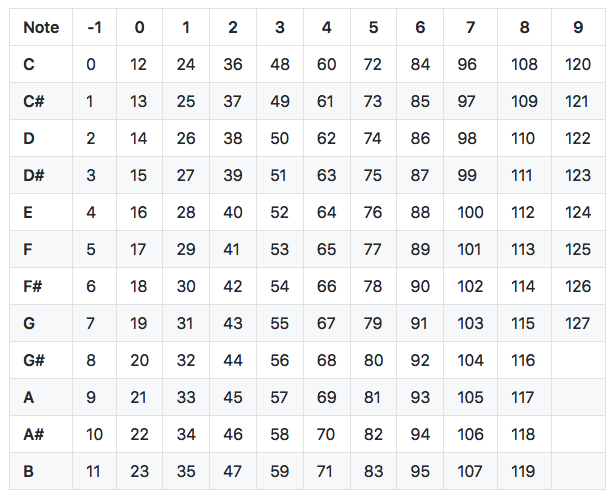



In [15]:
#Define one or more chords of choice in list and assign to chord variable
#Examples:
# chords = ['D-min','D-min','Cmaj','Cmaj','D-min','D-min','Cmaj','Cmaj','Cmaj']
chords = ['Emaj','F#-min7', 'Bmaj','C#-min','C#-min', 'Amaj', 'B7', 'B7']


#Input first note
normalized_notes = chord_context('28.0',chords, [], "")
d = duration.Duration(4.0)
q = stream.Stream()
for m in normalized_notes:
    q.append(note.Note(note.Note((m)).nameWithOctave))
i = 0.0
for chor in chords:
    q.insert(i, chord.Chord(chordDic[chor], duration=d))
    i = i + 4.0
mf = midi.translate.streamToMidiFile(q)
mf.open('/Users/Max/file_name_of_choice1.mid', 'wb')
mf.write()
mf.close()